# Data Exploration
### Authors: Jack Duryea (jd50), Shashank Mahesh (sm103)

In [1]:
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from scipy import stats
import glob
import data_utils
from collections import defaultdict

%matplotlib inline

## Load data

In [2]:
train_image_data = data_utils.get_train_images() 
train_mask_data  = data_utils.get_train_masks()
test_image_data = data_utils.get_test_images()

In [3]:
print "Number of train images:", len(train_image_data)
print "Number of test images: ", len(test_image_data)
print "Number of train masks: ", len(train_mask_data)

Number of train images: 670
Number of test images:  65
Number of train masks:  29461


### Current directory structure:


Data-Science-Bowl/ {   
    DataExploration.ipynb  
    Readme.md  
    stage1_sample_submission.csv  
    stage1_test/  
    stage1_train/  
    stage1_train/labels.csv 
    data_utils.py
   }
    

### Let's check out a few example images

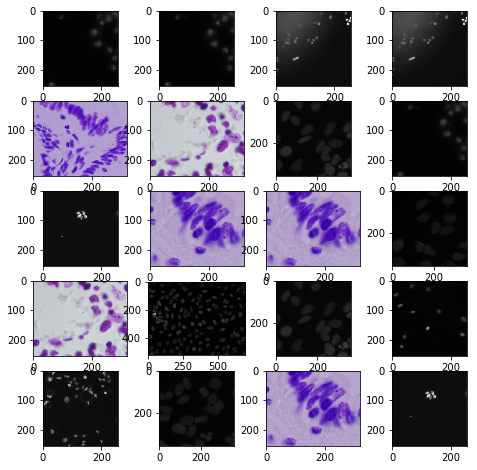

In [6]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    im = train_image_data[np.random.randint(i)].im
    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
plt.savefig("data_examples.png", dpi =10)
plt.show()


# Observation: Cell nuclei come in a wide variety of shapes and colors

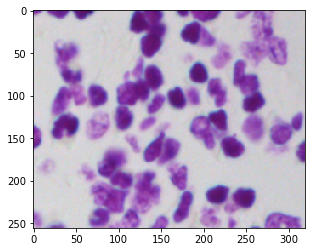

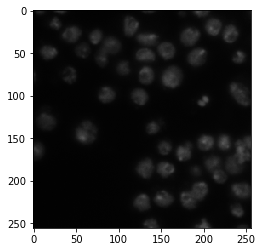

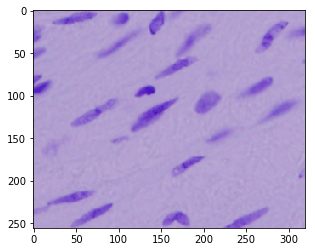

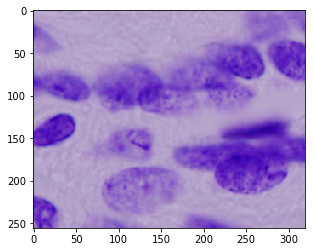

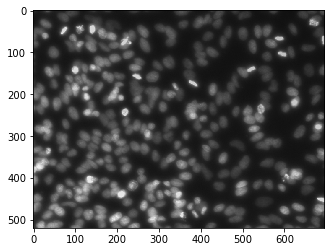

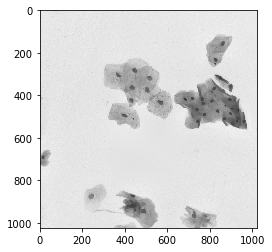

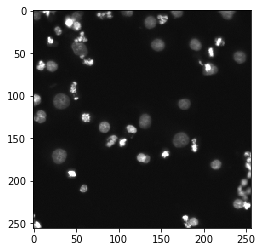

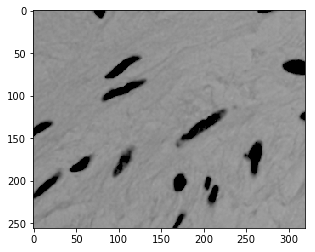

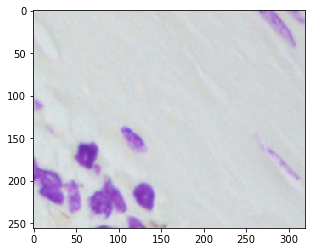

In [7]:
for i in range(1,10):
    im = imageio.imread("example_images/ex" + str(i) + ".png")
    plt.imshow(im)
    plt.show()

# Distribution of the number of nuclei in each image

In [9]:
outlier_images = []
nuclei_data_map = defaultdict(lambda:0) # map from dir_id to number of nuclei
for mask in train_mask_data:
    dir_id = mask.dir_id
    nuclei_data_map[mask.dir_id] += 1

for mask_dir_id in nuclei_data_map:
    if nuclei_data_map[mask_dir_id] > 200:
        outlier = [image for image in train_image_data if image.dir_id == mask_dir_id][0]
        outlier_images.append([outlier.im, nuclei_data_map[mask_dir_id]])
    

nuclei_data = nuclei_data_map.values()

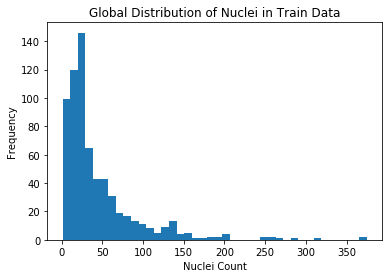

In [10]:
plt.xlabel("Nuclei Count")
plt.ylabel("Frequency")
plt.title("Global Distribution of Nuclei in Train Data")
plt.hist(nuclei_data, bins = 40);


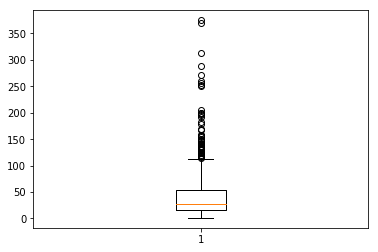

In [11]:
plt.boxplot(nuclei_data);

## Distribution statistics

In [12]:
stats.describe(nuclei_data)

DescribeResult(nobs=670, minmax=(1, 375), mean=43.971641791044775, variance=2300.4042768221675, skewness=2.865307317651728, kurtosis=11.325741184404169)

# Outlier images, images with lots of nuclei

Number of nuclei in below image:  253


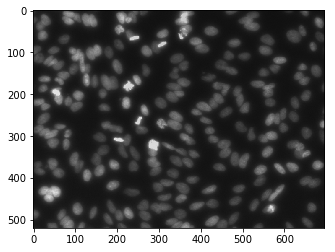

Number of nuclei in below image:  257


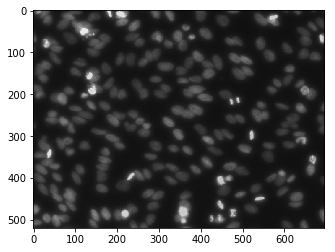

Number of nuclei in below image:  375


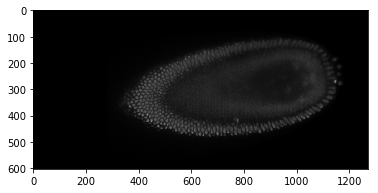

Number of nuclei in below image:  313


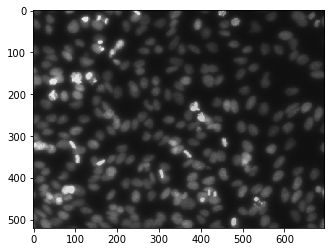

Number of nuclei in below image:  272


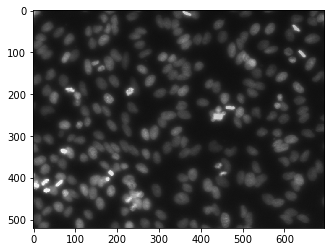

Number of nuclei in below image:  369


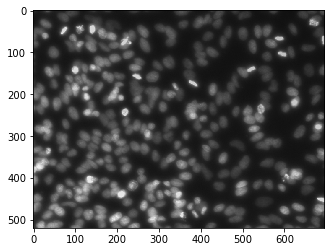

Number of nuclei in below image:  289


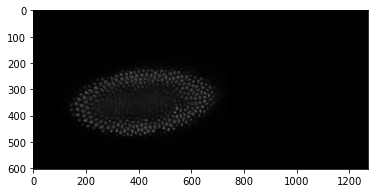

Number of nuclei in below image:  260


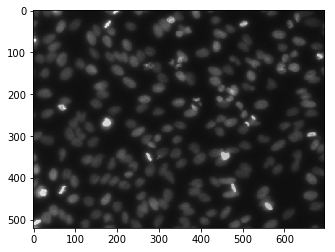

Number of nuclei in below image:  250


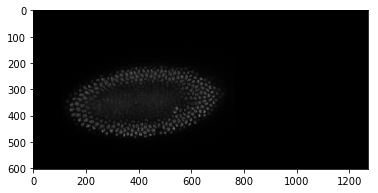

Number of nuclei in below image:  206


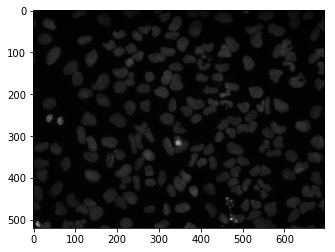

In [15]:
for image in outlier_images:
    plt.imshow(image[0]);
    print "Number of nuclei in below image: ", image[1]
    plt.show();

# Distribution of image sizes

In [16]:
image_size_data = [] # tuples of the form (width, height) 

for image in train_image_data:
    im = image.im
    w = im.shape[0]
    h = im.shape[1]
    image_size_data.append([w,h])

In [17]:
widths = np.array([x[0] for x in image_size_data])
heights = np.array([x[1] for x in image_size_data])

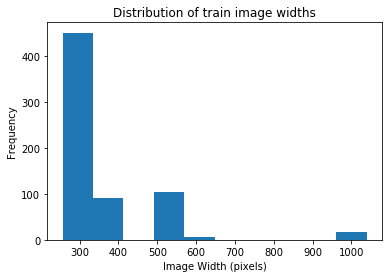

In [18]:
plt.xlabel("Image Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image widths")
plt.hist(widths);

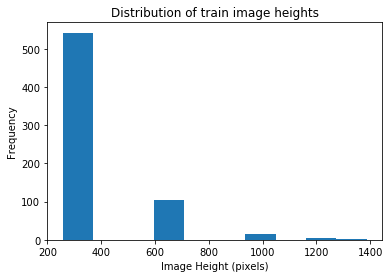

In [19]:
plt.xlabel("Image Height (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image heights")
plt.hist(heights);

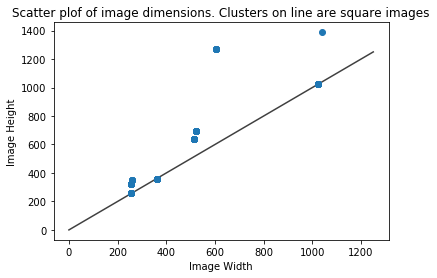

In [20]:
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Scatter plof of image dimensions. Clusters on line are square images")
plt.scatter(widths, heights);
plt.plot([0,1250],[0,1250], 'k-', alpha=0.75, zorder=0);


In [21]:
# Number of unique image dimensions

In [22]:
print "There are " + str(len(np.unique(image_size_data,axis=0))) + " unique image dimensions"

There are 9 unique image dimensions


In [23]:
print "Unique image dimensions"
sizes, counts = np.unique(image_size_data,axis=0, return_counts=True)
print sizes
print "Respective frequencies: " + str(counts)

Unique image dimensions
[[ 256  256]
 [ 256  320]
 [ 512  640]
 [1024 1024]
 [ 260  347]
 [ 520  696]
 [1040 1388]
 [ 603 1272]
 [ 360  360]]
Respective frequencies: [334 112  13  16   5  92   1   6  91]


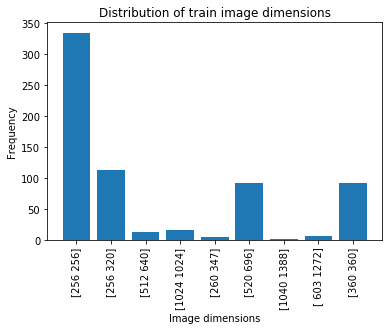

In [24]:
plt.xlabel("Image dimensions")
plt.ylabel("Frequency")
plt.title("Distribution of train image dimensions")
plt.bar(range(len(counts)), counts)
labels = [str(x) for x in np.unique(image_size_data,axis=0)]
plt.xticks(range(len(counts)),labels, rotation=90);

### Total number of pixels

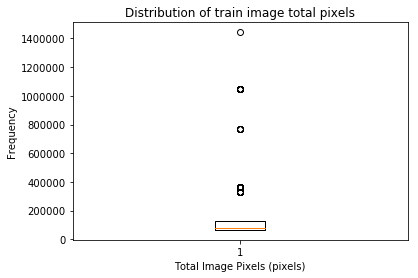

In [25]:
plt.xlabel("Total Image Pixels (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image total pixels")
plt.boxplot(widths*heights);

# Positions of nuclei in 256 x 256 images

In [26]:
# return the cooridnates 
def get_nuclei_pixels(image):
    return np.argwhere(image != 0)
    

In [29]:
ct = 0
imgs = []
x_coords = np.array([])
y_coords = np.array([])
for mask in train_mask_data:
    if mask.im.shape == (256,256):
        pixels = get_nuclei_pixels(mask.im)
        x = pixels[:,0]
        y = pixels[:,1]
        x_coords = np.append(x_coords,x)
        y_coords = np.append(y_coords,y)


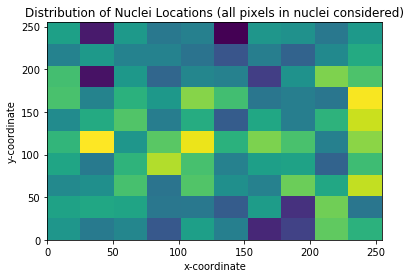

In [30]:
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Distribution of Nuclei Locations (all pixels in nuclei considered)")
plt.hist2d(x_coords, y_coords, bins=10);


### It seems that the pixels are uniformly distributed overall

# Nuclei Size in 256x256 images

We can measure the size of a nucleus by counting the number of pixels it contains

In [39]:
nuclei_sizes = []

for mask in train_mask_data:
    if mask.im.shape == (256,256):
        x = get_nuclei_pixels(mask.im)[:,0]
        num_pixels_in_mask = len(x)
        nuclei_sizes.append(num_pixels_in_mask)

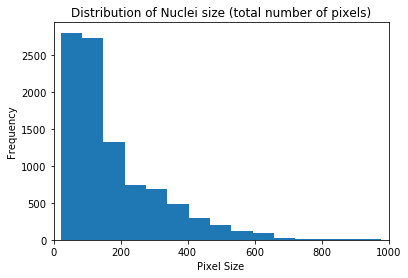

In [42]:
plt.title("Distribution of Nuclei size (total number of pixels)")
plt.xlabel("Pixel Size")
plt.ylabel("Frequency")
plt.xlim([0,1000])
plt.hist(nuclei_sizes, bins=30);

In [43]:
print "max nuclei size is : " + str(256**2)

max nuclei size is : 65536
